In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import math

def open_og_grid(og_path):
    with open(og_path, 'rb') as f:
        og = np.load(f)
    return og

og_path = '../dataset/Small_map/occupancy_grid.npy'
occupancy_grid = open_og_grid(og_path)

In [93]:
class AStarPlanner:

    def __init__(self, resolution, rr, obstacle_map= None, show_animation=True):
        """
        Initialize grid map for a star planning

        ox: x position list of Obstacles [m]
        oy: y position list of Obstacles [m]
        resolution: grid resolution [m]
        rr: robot radius[m]
        """

        self.resolution = resolution
        self.rr = rr
        self.min_x, self.min_y = 0, 0
        self.max_x, self.max_y = 0, 0
        self.x_width, self.y_width = 0, 0
        self.motion = self.get_motion_model()

        self.obstacle_map = obstacle_map
        self.get_og_map_info(obstacle_map)
        
        self.show_animation = show_animation
        if self.show_animation:
            self.fig = None
            self.ax = None
            self.pts = None
            self.x_plts = []
            self.y_plts = []
            self.txt_title = None
            self.anim = None
            self.sx = 0
            self.sy = 0
            self.gx = 0
            self.gy = 0
            self.rx = None
            self.ry = None
            

    
    def create_figure(self):
        self.fig = plt.figure(figsize=(10,10), dpi=120)
        self.ax = plt.subplot(1,1,1)   
        self.ax.imshow(self.obstacle_map, cmap='Greys')
        # set up the subplots as needed
        self.pts, = self.ax.plot([], [], 'g.', ms=6)
        self.ax.plot(self.sy, self.sx, "or", ms=12)
        self.ax.plot(self.gy, self.gx, "xb", ms=12)
        self.ax.grid(True)
        self.ax.set_xlim((self.min_x, self.max_x))            
        self.ax.set_ylim((self.min_y, self.max_y))
        self.ax.set_xlabel('Kierunek X')
        self.ax.set_ylabel('Kierunek Y')
       # ax.set_title('Planowanie trasy')
        
        self.txt_title = self.ax.set_title('')

    def ani_init(self):
        self.pts.set_data([], [])
        return self.pts,
    
    def animate(self, n):
        self.pts.set_data(self.y_plts[:n],self.x_plts[:n])
        self.txt_title.set_text('Algorythm step number = {0:4d}'.format(n))
        return self.pts,
    
    def create_animation(self):
        self.create_figure()
        self.anim = animation.FuncAnimation(self.fig, self.animate, init_func=self.ani_init,
                                            frames=len(self.x_plts), interval=10, blit=True)
        return self.anim
    
    def plot_searched_points(self):
        fig = plt.figure(figsize=(10,10), dpi=120)
        ax = plt.subplot(1,1,1)   
        plot_map = self.obstacle_map.copy()
      #  plot_map = np.flip(plot_map, axis=1)
        ax.imshow(plot_map, cmap='Greys')

        ax.grid(True)
        ax.set_xlim((self.min_x, self.max_x))            
        ax.set_ylim((self.min_y, self.max_y))
        ax.set_xlabel('Kierunek X')
        ax.set_ylabel('Kierunek Y')
        ax.plot(self.y_plts, self.x_plts,'g.', ms=6)
        ax.plot(self.sy, self.sx, "or", ms=12)
        ax.plot(self.gy, self.gx, "xb", ms=12)
        ax.plot(self.ry, self.rx, "r-", ms=8)
        plt.show()
      
    def get_og_map_info(self, og_map):
            self.max_x = round(og_map.shape[0])
            self.max_y = round(og_map.shape[1])
            self.x_width = round(self.max_x - self.min_x)
            self.y_width = round(self.max_y - self.min_y)
    
    @staticmethod
    def get_motion_model():
        # dx, dy, cost
        motion = [[1, 0, 1],
                  [0, 1, 1],
                  [-1, 0, 1],
                  [0, -1, 1],
                  [-1, -1, math.sqrt(2)],
                  [-1, 1, math.sqrt(2)],
                  [1, -1, math.sqrt(2)],
                  [1, 1, math.sqrt(2)]]

        return motion

    
    @staticmethod
    def calc_heuristic(n1, n2):
        w = 1.0  # weight of heuristic
        d = w * math.hypot(n1.x - n2.x, n1.y - n2.y)
        return d

    def calc_grid_index(self, node):
        return (node.y - self.min_y) * self.x_width + (node.x - self.min_x)

    def calc_grid_position(self, index, min_position):
        """
        calc grid position

        :param index:
        :param min_position:
        :return:
        """
        pos = index + min_position
        return pos

    def calc_xy_index(self, position, min_pos):
        return round(position - min_pos) 
    
    def verify_node(self, node):
        px = self.calc_grid_position(node.x, self.min_x)
        py = self.calc_grid_position(node.y, self.min_y)

        if px < self.min_x:
            return False
        elif py < self.min_y:
            return False
        elif px >= self.max_x:
            return False
        elif py >= self.max_y:
            return False

        # collision check
        if self.obstacle_map[node.x][node.y]: 
            return False
        return True

    def calc_final_path(self, goal_node, closed_set):
        # generate final course
        rx, ry = [self.calc_grid_position(goal_node.x, self.min_x)], [
            self.calc_grid_position(goal_node.y, self.min_y)]
        parent_index = goal_node.parent_index
        while parent_index != -1:
            n = closed_set[parent_index]
            rx.append(self.calc_grid_position(n.x, self.min_x))
            ry.append(self.calc_grid_position(n.y, self.min_y))
            parent_index = n.parent_index

        return rx, ry
    
    def planning(self, sx, sy, gx, gy):
        """
        A star path search

        input:
            s_x: start x position [m]
            s_y: start y position [m]
            gx: goal x position [m]
            gy: goal y position [m]

        output:
            rx: x position list of the final path
            ry: y position list of the final path
        """
        if self.show_animation:
            self.sx = sx
            self.sy = sy
            self.gx = gx
            self.gy = gy
        
        start_node = self.Node(self.calc_xy_index(sx, self.min_x),
                               self.calc_xy_index(sy, self.min_y), 0.0, -1)
        goal_node = self.Node(self.calc_xy_index(gx, self.min_x),
                              self.calc_xy_index(gy, self.min_y), 0.0, -1)

        open_set, closed_set = dict(), dict()
        open_set[self.calc_grid_index(start_node)] = start_node

        while 1:
            
            if len(open_set) == 0:
                print("Open set is empty..")
                break

            c_id = min(
                open_set,
                key=lambda o: open_set[o].cost + self.calc_heuristic(goal_node,
                                                                     open_set[
                                                                         o]))
            current = open_set[c_id]
            
            # show graph
            if self.show_animation:  # pragma: no cover
#                 sub_plt = plt.plot(self.calc_grid_position(current.x, self.min_x),
#                          self.calc_grid_position(current.y, self.min_y), "xc")
#                 self.plts.append(sub_plt)
                self.x_plts.append(self.calc_grid_position(current.x, self.min_x))
                self.y_plts.append(self.calc_grid_position(current.y, self.min_y))


            if current.x == goal_node.x and current.y == goal_node.y:
                print("Find goal")
                goal_node.parent_index = current.parent_index
                goal_node.cost = current.cost
                break

            # Remove the item from the open set
            del open_set[c_id]

            # Add it to the closed set
            closed_set[c_id] = current
            
            # expand_grid search grid based on motion model
            for i, _ in enumerate(self.motion):
                node = self.Node(current.x + self.motion[i][0],
                                 current.y + self.motion[i][1],
                                 current.cost + self.motion[i][2], c_id)
                n_id = self.calc_grid_index(node)

                # If the node is not safe, do nothing
                if not self.verify_node(node):
                    continue

                if n_id in closed_set:
                    continue

                if n_id not in open_set:
                    open_set[n_id] = node  # discovered a new node
                else:
                    if open_set[n_id].cost > node.cost:
                        # This path is the best until now. record it
                        open_set[n_id] = node
                  #      print('ID: {} \n Best path set: {}'.format(n_id,open_set[n_id]))

        if self.show_animation:
            self.anim = self.create_animation()
            
        self.rx, self.ry = self.calc_final_path(goal_node, closed_set)

        return self.rx, self.ry
    
    class Node:
        def __init__(self, x, y, cost, parent_index):
            self.x = x  # index of grid
            self.y = y  # index of grid
            self.cost = cost
            self.parent_index = parent_index

        def __str__(self):
            return str(self.x) + "," + str(self.y) + "," + str(
                self.cost) + "," + str(self.parent_index)

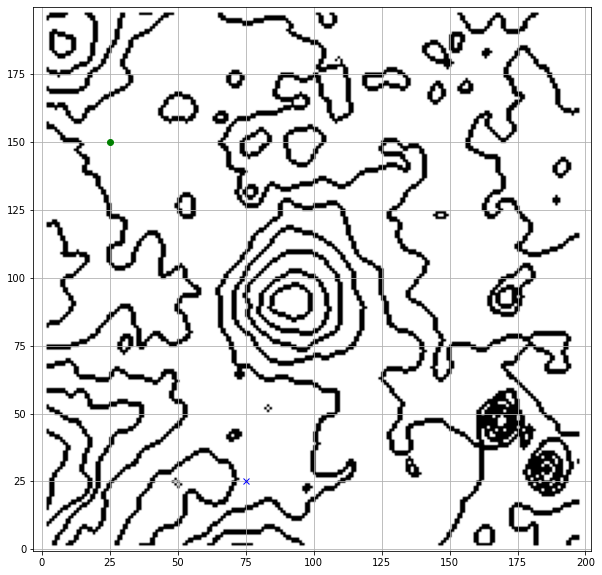

In [96]:

sx = 150.0  # [m]
sy = 25.0  # [m]
gx = 25.0  # [m]
gy = 75.0  # [m]
grid_size = 1 # 0.5  # [m]
robot_radius = 1.0  # [m]

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(occupancy_grid, cmap='Greys')

ax.plot(sy, sx, "og")
ax.plot(gy, gx, "xb")
ax.grid(True)
ax.axis("equal")
ax.invert_yaxis()

Find goal


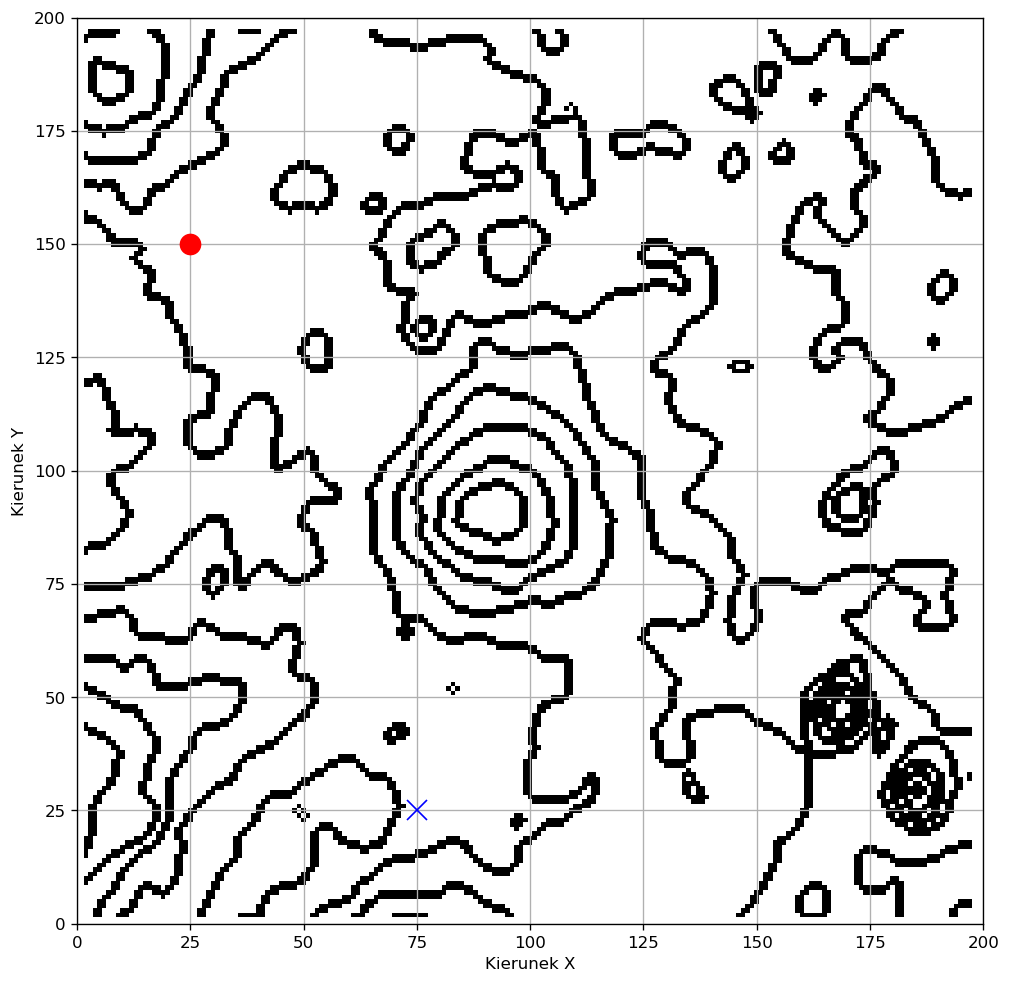

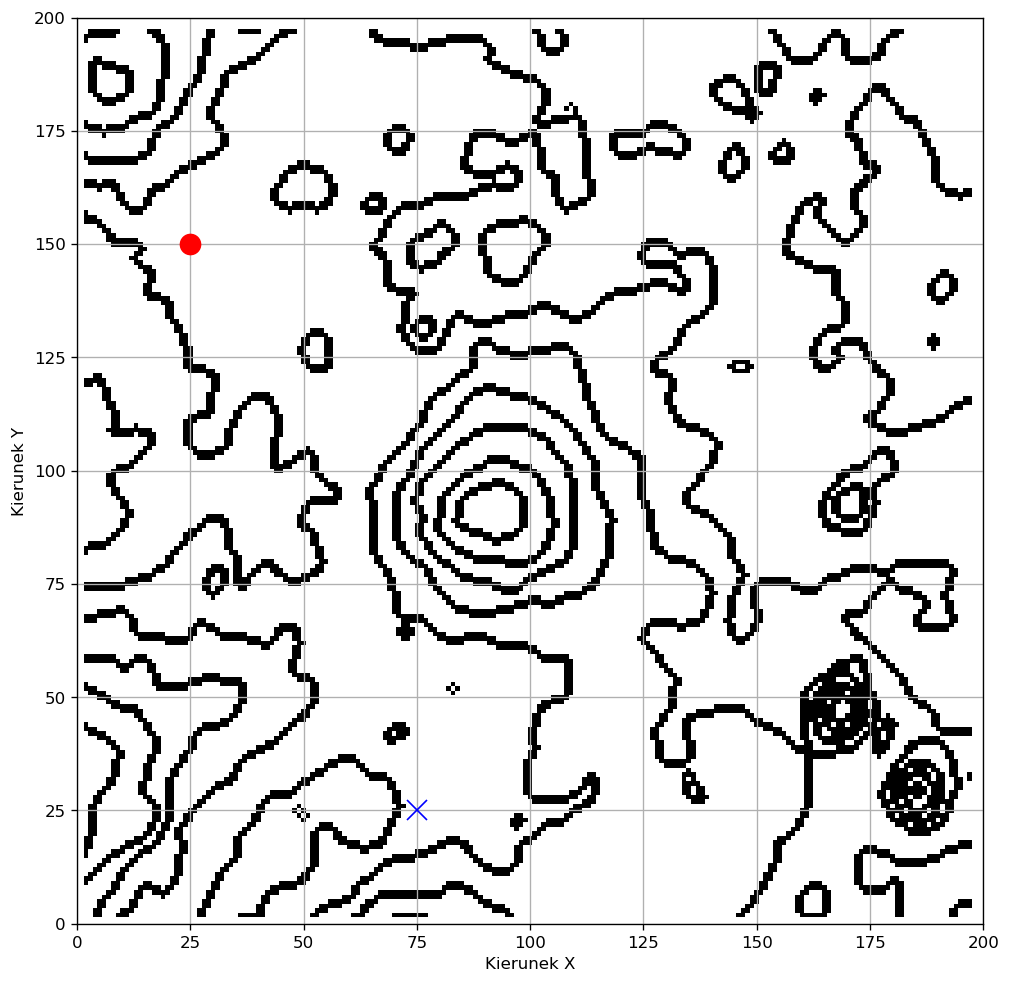

In [97]:
from IPython.display import HTML
from matplotlib import animation


a_star = AStarPlanner(resolution=1, rr=1, obstacle_map=occupancy_grid, show_animation=True)
rx, ry = a_star.planning(sx, sy, gx, gy)

# blit=True re-draws only the parts that have changed.
anim = a_star.create_animation()
#extra_args = ['vcodec',     'libx264']
#anim.save("../dataset/Small_map.mp4", fps = 30)


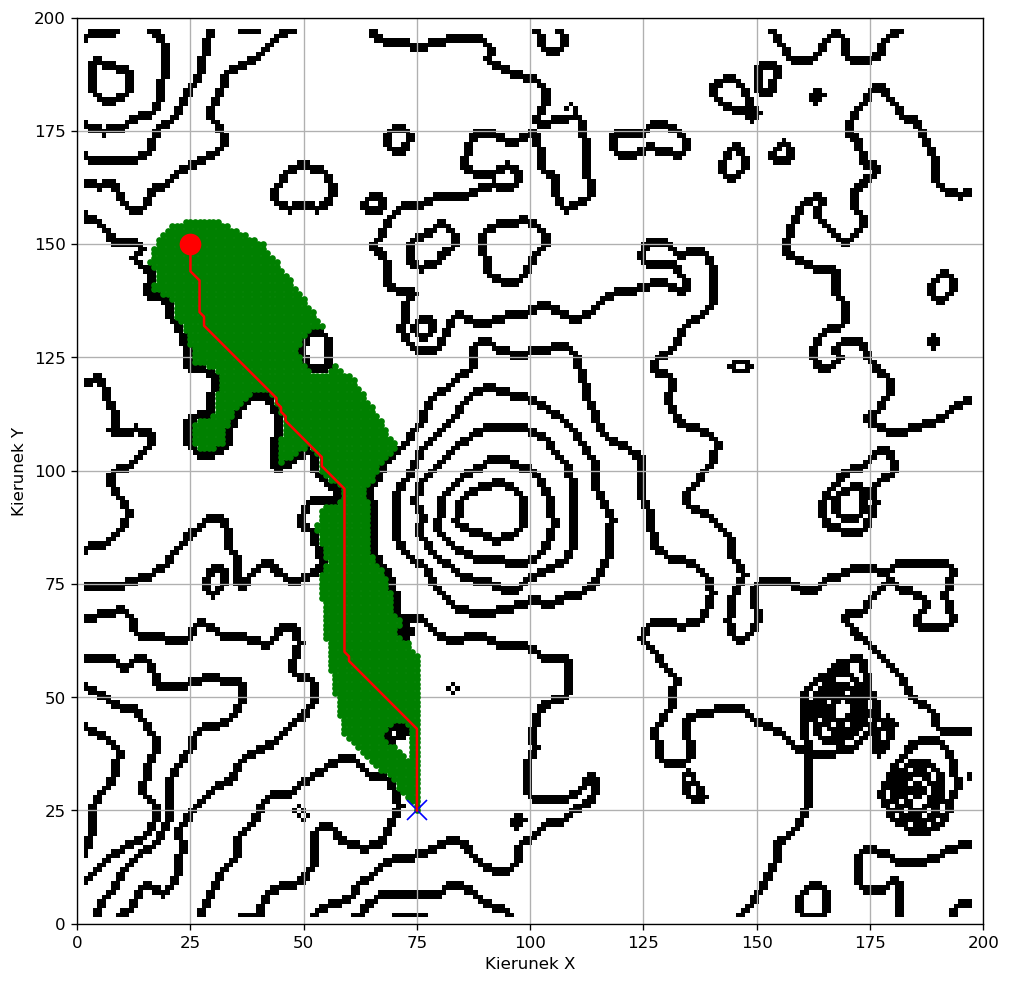

In [98]:
a_star.plot_searched_points()

In [ ]:
HTML(anim.to_html5_video())

In [23]:
print(len(a_star.x_plts))

5162


In [21]:
len(a_star.x_plts)
anim.save("../dataset/Small_map.mp4", fps = 30)